In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load the .mat file
data = scipy.io.loadmat('data/condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

In [3]:
# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [4, 5]]  # Select columns for muscle 5 and 6, which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Stack data for each condition
    go_envelope_all.append(torch.tensor(go_envelope_condition, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_condition, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_condition, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Print shapes
print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
print(f"Plan Tensor Shape: {plan_tensor.shape}")
print(f"Muscle Tensor Shape: {muscle_tensor.shape}")


/tmp/ipykernel_379228/1417502240.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  go_envelope_all.append(torch.tensor(go_envelope_condition, dtype=torch.float32))


Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


In [4]:
# Normalize and standardize a tensor
def normalize_and_standardize(tensor):
    # Normalize: Scale to 0-1 range
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)

    # Standardize: Shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std

    return tensor

# Apply the function to each tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = normalize_and_standardize(muscle_tensor)

# Print shapes to confirm
print(f"Normalized Go Envelope Tensor Shape: {normalized_go_envelope_tensor.shape}")
print(f"Normalized Plan Tensor Shape: {normalized_plan_tensor.shape}")
print(f"Normalized Muscle Tensor Shape: {normalized_muscle_tensor.shape}")


Normalized Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Normalized Plan Tensor Shape: torch.Size([216, 296, 15])
Normalized Muscle Tensor Shape: torch.Size([216, 296, 2])


In [5]:
import torch
import torch.nn as nn

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, x, torch.tanh(x))
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  # New linear layer

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh    
        
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration

        # Update hidden state
        hidden_update = torch.matmul(self.J, hidden.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))
        new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
        new_hidden = new_hidden.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)

        # Output calculation
        output = self.output_linear(hidden)

        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = (hidden - hidden_prev).pow(2).sum().sqrt()

        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 1.5  # g value
h = 1.0  # h value

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h)


In [6]:
import torch
import torch.nn as nn

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, x, torch.tanh(x))
    
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant

        # Modified weight initialization for a more chaotic regime (g >> 1)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float))))
        self.w = nn.Parameter(torch.zeros(output_size, hidden_size))
        self.bx = nn.Parameter(torch.zeros(hidden_size))
        self.bz = nn.Parameter(torch.zeros(output_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh    
    
    def forward(self, x, hidden):
        timestep = self.tau / 10  # Timestep for Euler integration
        for _ in range(int(1 / timestep)):  # Adjust the range for simulation duration
            hidden_update = torch.matmul(self.J, hidden.T)
            input_update = torch.matmul(self.B, x.T)
            new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)  
            new_hidden = new_hidden.T
    
            # Euler integration for continuous-time update
            hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)
        
        output = torch.matmul(self.w, hidden.T) + self.bz.unsqueeze(1)
        output = output.T
    
        return output, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

input_size = 16
hidden_size = 300
output_size = 2 # Number of muscles
g = 4 # Significantly larger g value for complicated model
h = 1.0 # h value remains the same

complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h)

In [7]:
# Convert datasets to TensorDataset and DataLoader for batch processing
from torch.utils.data import TensorDataset, DataLoader

# Concatenate along the third dimension (dim=2)
X_train = torch.cat((normalized_go_envelope_tensor, normalized_plan_tensor), dim=2)

# y_train remains the same
y_train = normalized_muscle_tensor

batch_size = 64  # You can adjust this based on your data size and memory constraints
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [8]:
# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg


Epoch 1, Loss: 4938.605224609375
Epoch 2, Loss: 1295.0733032226562
Epoch 3, Loss: 965.5600967407227
Epoch 4, Loss: 791.5160140991211
Epoch 5, Loss: 687.3917083740234
Epoch 6, Loss: 618.6651153564453
Epoch 7, Loss: 566.2944068908691
Epoch 8, Loss: 523.9398002624512
Epoch 9, Loss: 485.9263610839844
Epoch 10, Loss: 457.67305755615234
Epoch 11, Loss: 434.0043525695801
Epoch 12, Loss: 412.8926696777344
Epoch 13, Loss: 395.6022033691406
Epoch 14, Loss: 379.44727325439453
Epoch 15, Loss: 364.9649772644043
Epoch 16, Loss: 353.11585998535156
Epoch 17, Loss: 342.391414642334
Epoch 18, Loss: 332.4645195007324
Epoch 19, Loss: 323.6790466308594
Epoch 20, Loss: 315.0000762939453
Epoch 21, Loss: 306.9930610656738
Epoch 22, Loss: 299.6181411743164
Epoch 23, Loss: 292.6883773803711
Epoch 24, Loss: 286.3407440185547
Epoch 25, Loss: 280.4109916687012
Epoch 26, Loss: 274.64086532592773
Epoch 27, Loss: 269.39166259765625
Epoch 28, Loss: 264.0611686706543
Epoch 29, Loss: 259.2327079772949
Epoch 30, Loss: 25

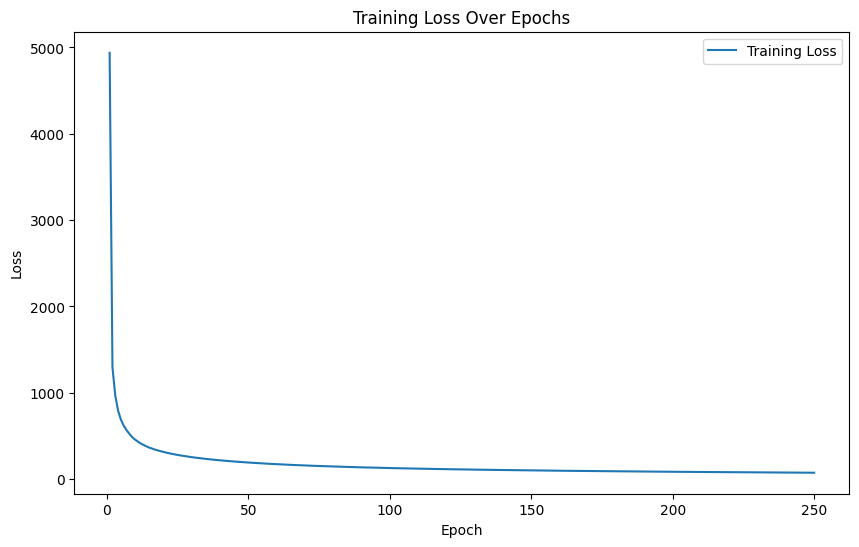

In [10]:
import matplotlib.pyplot as plt

# Hyperparameters for regularization
alpha = 1e-4  # Example value, adjust as necessary
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 250  # The number of times the entire dataset is passed through the network
epoch_losses = []  # List to store average loss of each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size) # Initialize hidden state with the current batch size
        optimizer.zero_grad()

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        # Process each time step in the inputs
        for t in range(inputs.shape[1]):
            output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
            total_firing_rate_reg += firing_rate_reg
            total_dynamic_reg += dynamic_reg
    
        # Compute loss using the last output and include regularization terms:
        loss = criterion(output, targets[:, -1, :])
        l2_reg = compute_l2_regularization(model.parameters(), alpha)
        rfr_reg = beta * total_firing_rate_reg / inputs.shape[1]  # Average over time steps
        rj_reg = gamma * total_dynamic_reg / inputs.shape[1]  # Average over time steps
    
        total_loss = loss + l2_reg + rfr_reg + rj_reg
        total_loss.backward()
        optimizer.step()
    
        running_loss += total_loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1, Loss: 0.6844498887658119
Epoch 2, Loss: 0.7684311643242836
Epoch 3, Loss: 0.7107953131198883
Epoch 4, Loss: 0.7505717277526855
Epoch 5, Loss: 0.7358348220586777
Epoch 6, Loss: 0.7848915904760361
Epoch 7, Loss: 0.6719830706715584
Epoch 8, Loss: 0.6876146793365479
Epoch 9, Loss: 0.8279480189085007
Epoch 10, Loss: 0.723111629486084
Epoch 11, Loss: 0.6876197457313538
Epoch 12, Loss: 0.7015645802021027
Epoch 13, Loss: 0.6643376275897026
Epoch 14, Loss: 0.7549911737442017
Epoch 15, Loss: 0.729726567864418
Epoch 16, Loss: 0.7364737838506699
Epoch 17, Loss: 0.6534652635455132
Epoch 18, Loss: 0.7946727126836777
Epoch 19, Loss: 0.7263908535242081
Epoch 20, Loss: 0.689399003982544
Epoch 21, Loss: 0.779498927295208
Epoch 22, Loss: 0.7836204171180725
Epoch 23, Loss: 0.7634584605693817
Epoch 24, Loss: 0.6947921067476273
Epoch 25, Loss: 0.6949298605322838
Epoch 26, Loss: 0.6603551581501961
Epoch 27, Loss: 0.717332735657692
Epoch 28, Loss: 0.7822877615690231
Epoch 29, Loss: 0.7155746817588806

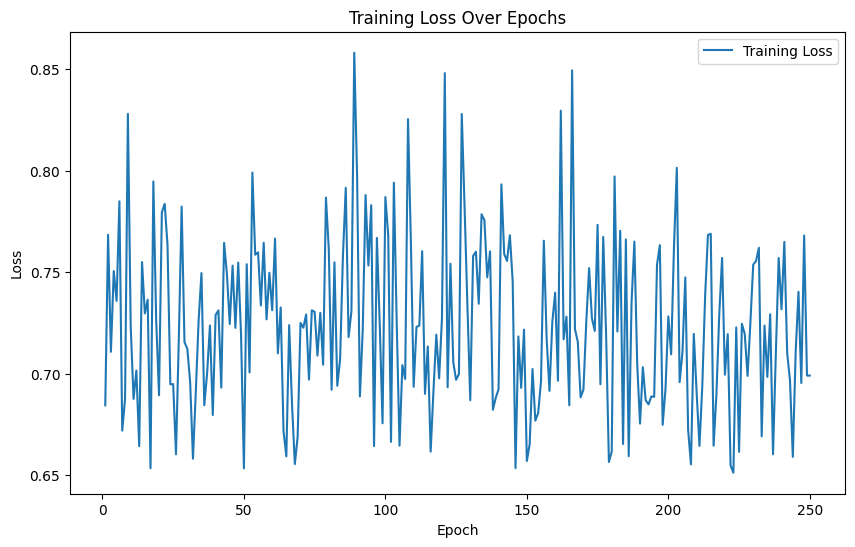

In [11]:
import matplotlib.pyplot as plt

# Training Loop
num_epochs = 250  # The number of times the entire dataset is passed through the network
epoch_losses = []  # List to store average loss of each epoch

# Loop over the dataset multiple times
for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize loss for this epoch

    # Iterate over the training data loader which provides batches of inputs and targets
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients to prevent accumulation

        batch_size = inputs.size(0)  # Get the batch size from the input tensor
        h = model.init_hidden(batch_size)  # Initialize hidden state with the current batch size

        # Process each time step in the input sequence
        for t in range(inputs.shape[1]):  # Iterate over time steps 
            output, h = complicated_model(inputs[:, t, :], h)  # Get output and updated hidden state

        # Compute loss using the last output (if your task is many-to-one)
        loss = criterion(output, targets[:, -1, :])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

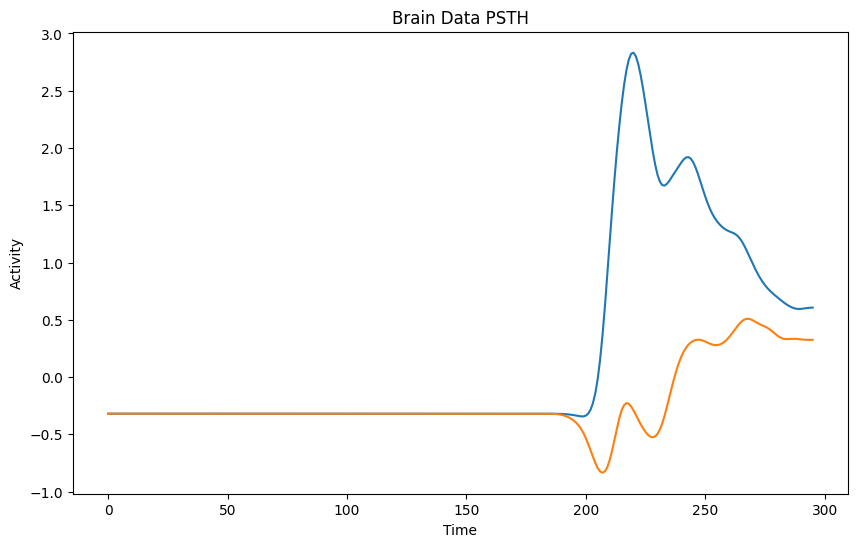

ValueError: all input arrays must have the same shape

In [12]:
import matplotlib.pyplot as plt

def plot_psth(data, title):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data
    :param title: a string for the plot title
    """
    # Mean across trials
    mean_data = data.mean(dim=0)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_data)
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title(title)
    plt.show()

# Plot PSTHs for brain data
plot_psth(normalized_muscle_tensor, "Brain Data PSTH")

def plot_rnn_psths(model, data_loader, title, max_time_steps):
    """
    Generate and plot PSTH-like plots for RNN hidden units.
    :param model: the RNN model
    :param data_loader: DataLoader containing input data
    :param title: a string for the plot title
    :param max_time_steps: maximum number of time steps in the sequences
    """
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient computations, since we don't need them during evaluation
        all_hidden_states = []  # List to collect hidden states from all batches

        for inputs, _ in data_loader:  # Iterate over batches
            h = model.init_hidden(inputs.size(0))  # Initialize the hidden state for this batch
            # Create an array to store hidden states for each time step of the current batch
            hidden_states = np.zeros((max_time_steps, h.shape[0], h.shape[1]))

            for t in range(inputs.shape[1]):  # Iterate over each time step
                _, h, _, _ = model(inputs[:, t, :], h)  # Forward pass for each time step, update hidden state
                hidden_states[t, :, :] = h.detach().numpy()  # Detach and store the hidden state

            all_hidden_states.append(hidden_states)  # Append the hidden states of the batch to the collection

        # Stack all hidden states and compute their mean across batches and time steps
        all_hidden_states_np = np.stack(all_hidden_states)
        avg_hidden_states = np.mean(all_hidden_states_np, axis=(0, 1))

        # Plot
        plt.figure(figsize=(10, 6))
        for i in range(avg_hidden_states.shape[1]):
            plt.plot(avg_hidden_states[:, i], label=f'Unit {i+1}')

        plt.xlabel('Time')
        plt.ylabel('Hidden Unit Activation')
        plt.title(title)
        plt.legend()
        plt.show()

# Determine the maximum number of time steps in your dataset
max_time_steps = max([inputs.shape[1] for inputs, _ in train_loader])

# Plot PSTH-like plots for RNN hidden units
plot_rnn_psths(model, train_loader, "RNN Hidden Units Activation", max_time_steps)

# Plot PSTH-like plots for RNN hidden units
plot_rnn_psths(complicated_model, train_loader, "RNN Hidden Units Activation", max_time_steps)

In [ ]:
# Function to add gaussian noise to the input data.
def perturb_inputs(inputs, noise_level=0.1):
    # Generating noise with the same shape as inputs
    noise = torch.randn_like(inputs) * noise_level
    # Adding the generated noise to the inputs and returning the noisy inputs
    return inputs + noise

# Function to add noise to the weights of a neural network model
def perturb_weights(model, perturbation_factor=0.1):
    # Iterating over all parameters (weights and biases) of the model
    for param in model.parameters():
        # Checking if the parameter is trainable 
        if param.requires_grad:
            # Adding in-place Gaussian noise to the parameter
            param.data.add_(torch.randn_like(param) * perturbation_factor)

# Function to evaluate the model's performance on a dataset
def evaluate_model(model, data_loader, criterion, complicated=False):
    # Setting the model to evaluation mode
    model.eval()
    total_loss = 0.0
    # Disabling gradient calculation as it's not needed during evaluation
    with torch.no_grad():
        # Iterating through the dataset using the data loader
        for inputs, targets in data_loader:
            # Determining the batch size from the input shape
            batch_size = inputs.size(0)
            # Initializing the hidden state of the model for the current batch
            h = model.init_hidden(batch_size)
            # Iterating over each time step in the input sequence
            for t in range(inputs.shape[1]):
                # Conditionally handling the model's forward pass based on the 'complicated' flag
                if complicated:
                    # For a 'complicated' model, forward pass with the current timestep's input and hidden state.
                    output, h = model(inputs[:, t, :], h)
                else:
                    # For a simpler model, forward pass with additional unused outputs
                    output, h, _, _ = model(inputs[:, t, :], h)
                    # Calculating the loss between the model output and the target for the last timestep
                    loss = criterion(output, targets[:, -1, :])
                    # Accumulating the loss for the current batch
                    total_loss += loss.item()
                    # Returning the average loss across all batches in the data loader
                return total_loss / len(data_loader)
                
def assess_robustness(model, data_loader, criterion, perturb_function, perturbation_level, complicated=False):
    # Evaluate on non-perturbed data
    original_loss = evaluate_model(model, data_loader, criterion, complicated)
    # Perturb model
    perturb_function(model, perturbation_level)
    # Evaluate on perturbed data
    perturbed_loss = evaluate_model(model, data_loader, criterion, complicated)
    return original_loss, perturbed_loss

In [ ]:
# Evaluate and compare robustness
simple_original_loss, simple_perturbed_loss = assess_simple_robustness(model, train_loader, criterion, perturb_weights, 0.1)
complex_original_loss, complex_perturbed_loss = assess_complicated_robustness(complicated_model, train_loader, criterion, perturb_weights, 0.1)

print(f"Simple Model - Original Loss: {simple_original_loss}, Perturbed Loss: {simple_perturbed_loss}")
print(f"Complex Model - Original Loss: {complex_original_loss}, Perturbed Loss: {complex_perturbed_loss}")
